In [1]:
import logging

from rdkit import Chem
from rdkit.Chem import Draw
from tooltoad.chemutils import xyz2mol
from tooltoad.ndscan import ScanCoord, PotentialEnergySurface

scan_logger = logging.getLogger("ndscan")
scan_logger.setLevel(logging.INFO)
scan_logger.addHandler(logging.StreamHandler())

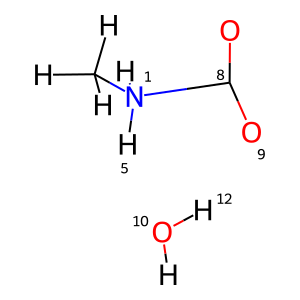

In [2]:
xyz = """13

C     -1.820137    0.791056    0.832598
N     -0.990792    0.327003   -0.268100
H     -1.645793    0.153047    1.697147
H     -2.888298    0.779865    0.596600
H     -1.523628    1.808782    1.086876
H     -1.131170   -0.663987   -0.463146
H     -1.182516    0.857131   -1.111779
O      0.990856    1.702911    0.540866
C      0.983091    0.616915    0.130413
O      1.438608   -0.409583   -0.190907
O     -0.415522   -2.481391   -0.868919
H     -0.287494   -3.370991   -0.534832
H      0.433595   -2.026999   -0.782961
"""

mol = xyz2mol(xyz)

for idx in [1, 8, 5, 9, 10, 12]:
    mol.GetAtomWithIdx(idx).SetProp("atomNote", str(idx))
Draw.MolToImage(mol)

## Set up the coordinate scan

Define scan coordinates as list of dictionaries with the keys:
* `atom_ids` (indexed from 0)
* `start` 
* `end`
* `nsteps`

Alternatively, scan coordinates can be defined based on the current geometry of the structure:


```
scan_coords = [
    ScanCoord.from_current_position(atoms, coords, [1, 8], 15),
    ScanCoord.from_current_position(atoms, coords, [5, 10], 15),
    ScanCoord.from_current_position(atoms, coords, [9, 12], 15),
]
```

The first scan coordinate in the list is scanned by 1D xTB scans, all following coordinates are scanned via constraints.
It therefore is best to have the coordinate with the most steps as the first one to decrease overhead.

In [3]:
atoms = [a.GetSymbol() for a in mol.GetAtoms()]
coords = mol.GetConformer().GetPositions()

scan_coords = [
    ScanCoord.from_current_position(atoms, coords, [1, 8], nsteps=15),
    ScanCoord.from_current_position(atoms, coords, [5, 10], nsteps=15),
    ScanCoord.from_current_position(atoms, coords, [9, 12], nsteps=15),
]

## Perform the n-dimensional scan

A n-dimensional is performed via several 1D scans and the results are collected in n-dimensional tensors:
* `scan_tensor`: Storing the respective values of the coordinates
* `pes_tensor`: Storing the respective potential energy
* `traj_tensor`: Storing the respective coordinates

In [4]:
pes = PotentialEnergySurface(
    atoms=atoms, coords=coords, charge=0, multiplicity=1, scan_coords=scan_coords
)
pes

PotentialEnergySurface with 13 atoms and 3 scan coordinates

In [5]:
pes.xtb(n_cores=-1, max_cycle=5, force_constant=1.0)

1-dimensional scans: 100%|██████████| 225/225 [00:42<00:00,  5.32it/s]


Plot specific slice of the PES

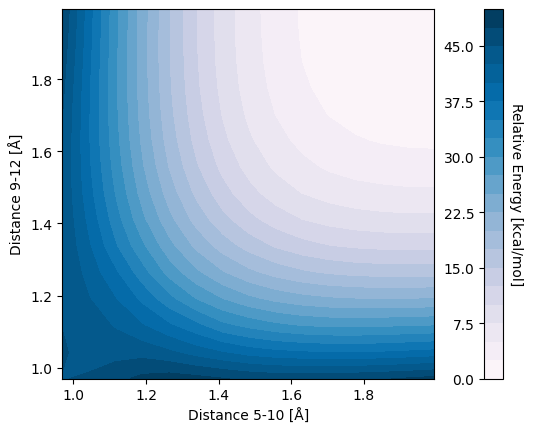

In [6]:
_ = pes.plot_2d(coord_slice=[0, slice(None), slice(None)])

### Find and plot stationary points on the PES

In [7]:
saddle_points = pes.find_stationary_points(point_type="saddle", tolerance=1e-2)
saddle_points

[{'idx': (11, 11, 10),
  'energy': -22.948706936415,
  'grad_norm': 0.0005645097469068686}]

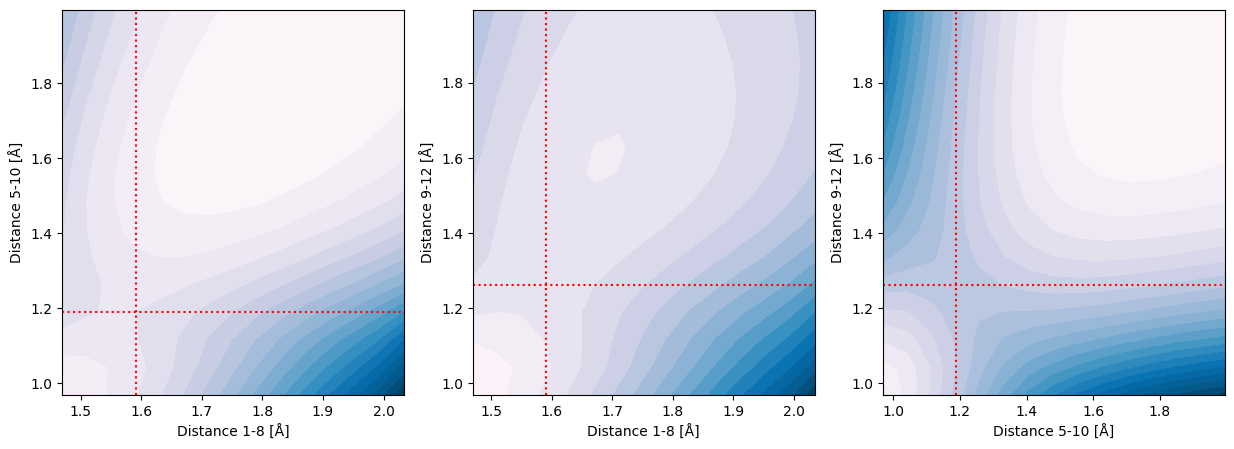

In [8]:
_ = pes.plot_point(saddle_points[0]["idx"])

In [9]:
ts_coords = pes.traj_tensor[saddle_points[0]["idx"]]
ts_coords

array([[-1.73038481,  0.66748492,  0.81371433],
       [-0.88989077,  0.25678649, -0.30785573],
       [-1.57310669, -0.02497657,  1.64006255],
       [-2.77906201,  0.64334116,  0.52087881],
       [-1.47142754,  1.6730823 ,  1.15177297],
       [-0.93381304, -1.03757714, -0.6387812 ],
       [-1.08869877,  0.8434689 , -1.11488782],
       [ 0.96302162,  1.52588703,  0.44324365],
       [ 0.65201546,  0.45731414,  0.02063014],
       [ 1.3145118 , -0.58003715, -0.21514068],
       [-0.4533807 , -2.10117149, -0.8727442 ],
       [-0.63145947, -2.71481293, -0.15553456],
       [ 0.58247494, -1.52503067, -0.62150227]])